# PolEval Task 6.1
This notebook is the proposed solution to the 6th task of PolEval 2019 challenge.  
http://poleval.pl/tasks/task6

The goal of the contestants will be to classify the tweets into cyberbullying/harmful and non-cyberbullying/non-harmful with the highest possible Precision, Recall, balanced F-score and Accuracy. In an additional sub-task, the contestants will differentiate between various types of cyberbullying, i.e., revealing of private information, personal threats, blackmails, ridiculing, gossip/insinuations, or accumulation of vulgarities and profane language.

In [1]:
import pickle
import re
import os

import fasttext
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             f1_score, recall_score, precision_score)

# Load data

In [2]:
def load_tweets(path):
    with open(path, 'r', encoding='utf-8') as f:
        tweets = f.readlines()
    return tweets

def load_labels(path):
    with open(path, 'r') as f:
        labels = []
        for line in f.readlines():
            labels.append(int(line.strip()))
    return labels

In [3]:
DATA_PATH = os.path.join(os.sep, 'project', 'data')

training_tweets = load_tweets(os.path.join(DATA_PATH, 'training_set_clean_only_text.txt'))
training_labels = load_labels(os.path.join(DATA_PATH, 'training_set_clean_only_tags.txt'))

testing_tweets = load_tweets(os.path.join(DATA_PATH,
                                          'evaluation',
                                          'test_set_clean_only_text.txt'))
testing_labels = load_labels(os.path.join(DATA_PATH,
                                          'evaluation',
                                          'test_set_clean_only_tags.txt'))

# Load embedding model

In [4]:
model = fasttext.load_model('../model.bin')

# Data exploration

## Classes

Text(0.5, 0, 'Class')

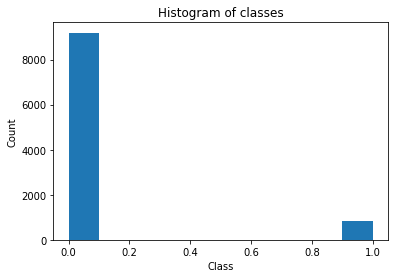

In [5]:
plt.hist(training_labels);
plt.title('Histogram of classes')
plt.ylabel('Count')
plt.xlabel('Class')

In [6]:
percentage_of_harmful = round(sum(training_labels)/len(training_labels)*100,2)
print("Harmful tweets make {}% of training data".format(percentage_of_harmful))

Harmful tweets make 8.48% of training data


We see that harmful tweets make only ~8.5% of all the training data meaning that the dataset is highly unbalanced. Thus, we should take it into the consideration when training the classifier and evaluating it. The standard metric, namely the accuracy won't be suitable here as with such distribution of clasess we could achieve above 90% accuraccy simply by assigining the majority class to all observations. 

## Features
Tweets embedded in 100 dimensional space using the FastText model
trained on texts scraped from Polish websites.

In [7]:
def clean_tweet(tweet: str) -> str:
    """
    Removes non alpha characters and 
    `@anonymized_account` tokens.
    """
    
    cleaned = tweet.lower()
    cleaned = re.sub('@anonymized_account', '', cleaned)
    cleaned = re.sub(r'[\d+]|[^\w\s]', '',
                     cleaned).strip()
    
    return cleaned


def tokenize(tweet: str) -> list:
    return tweet.split()


def vectorize_tokens(tokens: list, model) -> np.array: 
    """
    Embedds individual words in high dimensional space
    and returns averaged representation of them.
    """
    
    embeddings = []
    for token in tokens:
        embedding = model[token]
        embeddings.append(embedding)
    
    if len(embeddings) == 0:
        embeddings = [0] * len(model['a'])
    
    embeddings = np.asarray(embeddings)
    
    return np.mean(embeddings, axis=0)


def embedd_tweets(tweets: list, n_dimensions=100) -> np.array:
    """
    Returns averaged embedding for each tweet
    in the list.
    """
    
    embedded_tweets = np.zeros(shape=(len(tweets), n_dimensions))
    for i, tweet in enumerate(tweets):
        cleaned = clean_tweet(tweet)
        tokens = tokenize(cleaned)
        embedded_tweet = vectorize_tokens(tokens, model)

        embedded_tweets[i] = embedded_tweet
        
    return embedded_tweets

In [9]:
embedded_tweets_training = embedd_tweets(training_tweets)

### Visualise features in two-dimensional space

In [10]:
reduced = TSNE(n_components=2).fit_transform(embedded_tweets_training)

Text(0.5, 1.0, 'Visualisation of tweets embeddings (T-SNE)')

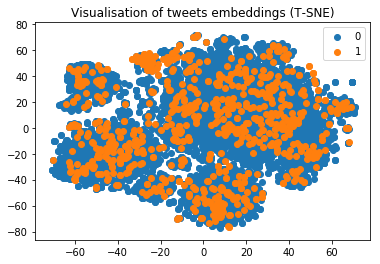

In [12]:
for class_ in np.unique(training_labels):
    class_points = reduced[training_labels == class_]
    plt.scatter(class_points[:, 0],
                class_points[:,1], label=class_)
plt.legend()
plt.title("Visualisation of tweets embeddings (T-SNE)")

Features don't seem to be easily separable.

# Training

In [13]:
svm = LinearSVC(random_state=42, max_iter=10000, class_weight='balanced')

In [14]:
clf = GridSearchCV(svm,
                   param_grid={'C': [2**x for x in range(-8, 8, 2)]},
                   scoring='f1',
                   cv=5, n_jobs=10, verbose=1)

In [16]:
clf.fit(embedded_tweets_training, training_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='warn', n_jobs=10,
             param_grid={'C': [0.00390625, 0.015625, 0.0625, 0.25, 1, 4, 16,
                               64]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [17]:
with open('classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Evaluation

In [18]:
embedded_tweets_test = embedd_tweets(testing_tweets)

In [19]:
preds = clf.predict(embedded_tweets_test)
with open(os.path.join(DATA_PATH, 'evaluation', 'predictions.txt'), 'w') as f:
    f.writelines("\n".join([str(x) for x in preds.tolist()]))

In [20]:
cm = confusion_matrix(y_pred=preds, y_true=testing_labels)
accuracy = accuracy_score(y_pred=preds, y_true=testing_labels)
recall = recall_score(y_pred=preds, y_true=testing_labels)
precision = precision_score(y_pred=preds, y_true=testing_labels)
f1 = f1_score(y_pred=preds, y_true=testing_labels)

In [21]:
print(cm)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("f1: ", f1)

[[648 218]
 [ 47  87]]
Accuracy:  0.735
Recall:  0.6492537313432836
Precision:  0.28524590163934427
f1:  0.39635535307517084


# Conculsion
Our solution is able to "find" around 65% of harmful tweets among all tweets in the test set. At the same time
it correctly identifies tweet as harmful in 28% of cases meaning that we ofthen classifies tweet as harmful although it actually is unharmful. 